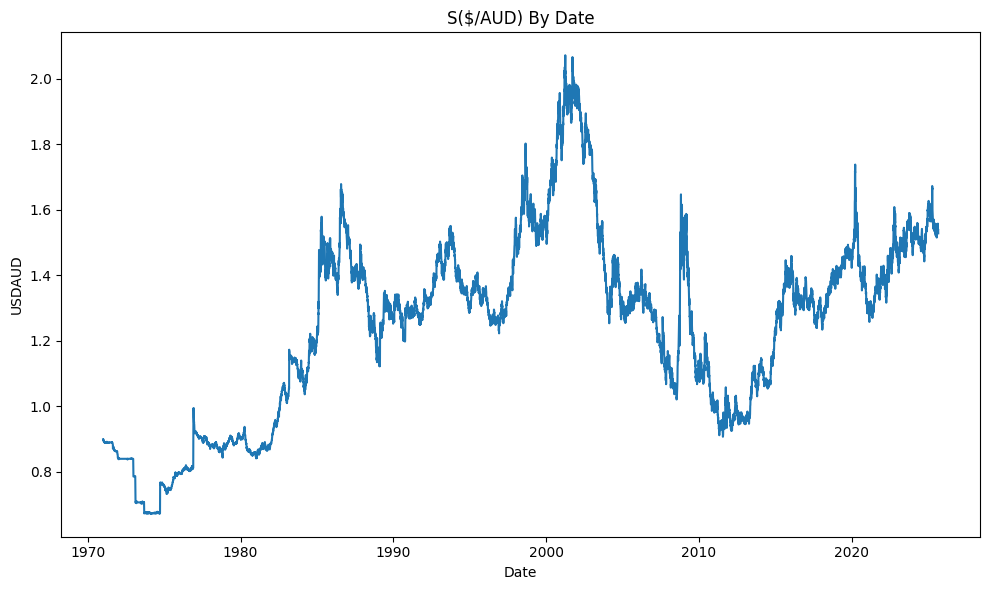

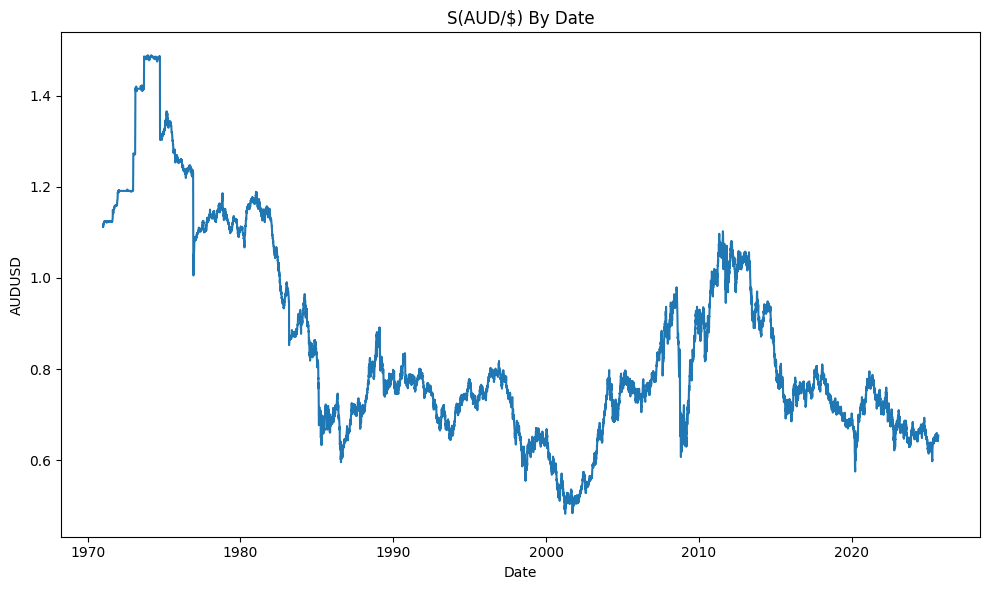

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from dotenv import load_dotenv
import os
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_percentage_error
import fredapi as fr
load_dotenv()
FRED_API_KEY = os.getenv("FRED_API_KEY")






fred = fr.Fred(api_key=FRED_API_KEY)



AUDUSD = fred.get_series("DEXUSAL")
AUDUSD.name = "AUDUSD"

df = pd.concat([AUDUSD],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

df['USDAUD'] = 1 / df['AUDUSD']



plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDAUD',data=df)
plt.title("S($/AUD) By Date")
plt.savefig("images/spotrate-aud-usd.png")
plt.tight_layout()
plt.show()




plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='AUDUSD',data=df)
plt.title("S(AUD/$) By Date")
plt.savefig("images/spotrate-aud-usd.png")
plt.tight_layout()
plt.show()





In [2]:
df.drop("AUDUSD",axis=1,inplace=True)
training = df.iloc[:,1:2].values
train_size = int(len(training) * .80)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)







def slider(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 4

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out



bidirectional_lstm = BiLSTM(input_size=1,hidden_size=64,num_layers=2,output_size=1)
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=bidirectional_lstm.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()


for epoch in range(epochs):
    y_pred = bidirectional_lstm(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    bidirectional_lstm.eval()
    with torch.no_grad():
        y_pred = bidirectional_lstm(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  bidirectional_lstm(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RMSE: {train_rmse:.4}; Test RMSE: {test_rmse:.4}')

/tmp/ipykernel_32821/1673211815.py:79: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_32821/1673211815.py:81: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RMSE: 0.5014; Test RMSE: 0.5982
Epoch: 1; train_RMSE: 0.4785; Test RMSE: 0.5729
Epoch: 2; train_RMSE: 0.4558; Test RMSE: 0.5474
Epoch: 3; train_RMSE: 0.4331; Test RMSE: 0.5216
Epoch: 4; train_RMSE: 0.4101; Test RMSE: 0.4951
Epoch: 5; train_RMSE: 0.3867; Test RMSE: 0.4677
Epoch: 6; train_RMSE: 0.3629; Test RMSE: 0.4391
Epoch: 7; train_RMSE: 0.3385; Test RMSE: 0.409
Epoch: 8; train_RMSE: 0.3137; Test RMSE: 0.3772
Epoch: 9; train_RMSE: 0.2887; Test RMSE: 0.3432
Epoch: 10; train_RMSE: 0.264; Test RMSE: 0.307
Epoch: 11; train_RMSE: 0.2406; Test RMSE: 0.2682
Epoch: 12; train_RMSE: 0.2203; Test RMSE: 0.2271
Epoch: 13; train_RMSE: 0.2057; Test RMSE: 0.1842
Epoch: 14; train_RMSE: 0.1995; Test RMSE: 0.1411
Epoch: 15; train_RMSE: 0.2031; Test RMSE: 0.1021
Epoch: 16; train_RMSE: 0.2139; Test RMSE: 0.07488
Epoch: 17; train_RMSE: 0.2258; Test RMSE: 0.06525
Epoch: 18; train_RMSE: 0.2333; Test RMSE: 0.06606
Epoch: 19; train_RMSE: 0.2343; Test RMSE: 0.06679
Epoch: 20; train_RMSE: 0.2296

In [3]:
with torch.no_grad():
    pred = bidirectional_lstm(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)


#r2 score
r2 = r2_score(actual_rescaled,pred_rescaled)
print(f'R2-Score: {r2*100:.2f}%')


mape = mean_absolute_percentage_error(actual_rescaled,pred_rescaled)
print(f'Mean Absolute Percentage Error: {mape:.4}')

rmse = root_mean_squared_error(actual_rescaled,pred_rescaled)
print(f'Root Mean Squared Error: {rmse:.4}')


test_dates = df.iloc[train_size + seq_length:]['Date']


comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate":pred_rescaled.flatten()
})
print(comparison_df.head(20))
print(comparison_df.tail(20))

R2-Score: 98.52%
Mean Absolute Percentage Error: 0.006771
Root Mean Squared Error: 0.0126
            Date  Actual Spot Rate  Predicted Spot Rate
10964 2014-09-16          1.099384             1.097523
10965 2014-09-17          1.107665             1.098645
10966 2014-09-18          1.113090             1.101400
10967 2014-09-19          1.119194             1.103623
10968 2014-09-22          1.126634             1.106931
10969 2014-09-23          1.129561             1.113833
10970 2014-09-24          1.127396             1.119263
10971 2014-09-25          1.136880             1.122511
10972 2014-09-26          1.141422             1.127151
10973 2014-09-29          1.144427             1.131037
10974 2014-09-30          1.144558             1.134890
10975 2014-10-01          1.144951             1.138901
10976 2014-10-02          1.137268             1.140789
10977 2014-10-03          1.152738             1.139296
10978 2014-10-06          1.143249             1.142092
10979 2014-10-

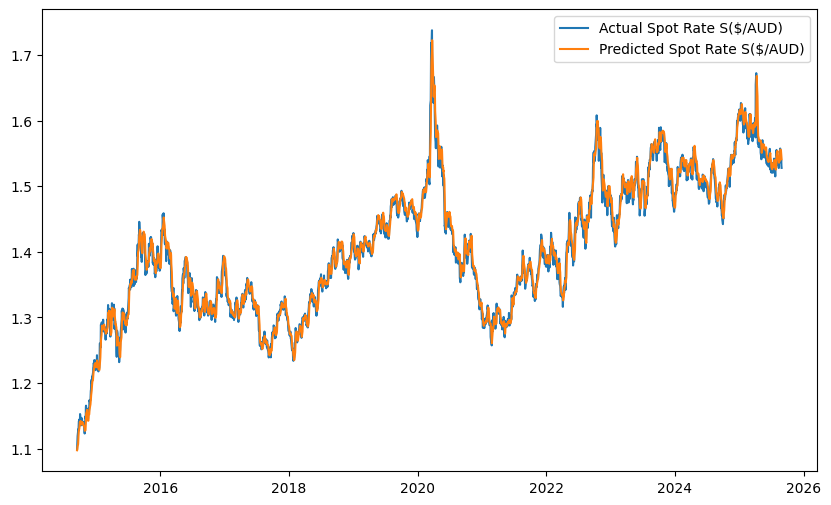

In [4]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate S($/AUD)")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate S($/AUD)")
plt.legend()
plt.savefig("images/predicted_vs_actual-usd-aud.png")
plt.show()